# Data Gathering

In [81]:
%matplotlib inline

In [2]:
from utils.io import gdf_viewer, gdf_merger, data_validation, gdf_filter, fix_duplicates
import re, os
import numpy as np
import geopandas as gpd
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt
from definitions import ROOT_DIR

In [3]:
def files_search(work_dir, files_dict, prefix='', skip=None, details=False):   
    
    if skip is None:
        skip = "we don't want to skip a word"
        
    for k in files_dict.keys():
        tmp_list = []
        for p,d,f in os.walk(work_dir):
            for x in f:
                add = False
                if re.search(prefix,x,re.I) and not re.search(skip,x,re.I):
                    add = True
                    i = str(f'{p}/{x}')
                else:
                    add = False
                    i=''
                    
                if re.search(k,i,re.I) and add:
                    tmp_list.append(i)
        tmp_list.sort()
        files_dict.update({k:tmp_list})

    for k,v in files_dict.items():
        print(k,' \t: ',len(v))
    
    if details: # Look filenames
        which = files_dict.keys()

        for w in which:
            print('\n+++++++++++++++++')
            print(f'+  {w.upper()}\t+ ')
            print('+++++++++++++++++')
            [print(i, '-', x) for i, x in enumerate(files_dict[w], 0)]    


In [4]:
def create_df(files, verbose=True): # find another name for this function
    """
    create dataframes from files and test if they contain position informations
    files: list of files name
    """
    dfs = []
    for f in files:
        df = pd.read_csv(f, delimiter=',')
        dfs.append(df)
        
        if verbose:
            if 'X' in list(df.columns): msg = ' --> Coordinates'
            else: msg = ' --> No coordinates'

            print(f"df1 : {msg}")
            
    return dfs

In [5]:
def dataset_overview(d, verbose=False): # check for same datasets in given files
    """d: dict
    """
    l = len(d)
    with_coord = []
    no_coord = []
    same = []
    
    for i in range(l-1):
        for j in range(i,l):
            a, b = create_df([d[i], d[j]], verbose)
            if j != i:
                if a.equals(b):
                    same.append((i,j))
            
            if 'X' in list(b.columns) and j not in with_coord:
                with_coord.append(j)
            elif 'X' not in list(b.columns) and j not in no_coord:
                no_coord.append(j)
    
    print(f'Same files:{same}\nFiles with coordinates:{with_coord}\nFiles without coordinates:{no_coord}')

## Reading files

In [6]:
work_dir = ROOT_DIR+'/CF_data/Result_traitem/'
save_dir = ROOT_DIR+'/CF_data/Donnees_fusionnees/'

In [7]:
# create my dictionary structure to retrieve good files (Keynames !!!)
files_dict={'Borehole':0,'Piezometer':0,'Piezair':0,'Trench':0,'Litho':0,'Equipm':0,
        'Measure':0,'Sample':0,'Analysis':0,'Facility':0}

In [8]:
files_search(work_dir, files_dict, prefix='', skip='source')

Borehole  	:  7
Piezometer  	:  17
Piezair  	:  2
Trench  	:  1
Litho  	:  8
Equipm  	:  3
Measure  	:  6
Sample  	:  27
Analysis  	:  21
Facility  	:  4


In [9]:
how=['inner', 'outer', 'left', 'right']

In [10]:
f = False
t = True

# ================== PROCESSING ===================== 

# Boreholes

Some corrections todo in 'data organization':
- correct extraction in the file 2 -> Samples
- file 4 and file 5 are the same in result (check it)
- try to concatenate file 1 with piezo (if possible because no position)
- check processing for 'refus and 'type_refus' (every object)

In [11]:
key='Borehole'
save_file = f'Merged_Boreholes.csv'
coi=['ID','ID_date','X','Y','Z','Type','Long_for','Diam_for','Refus', 'Societe'] #columns of interest
dataset = pd.DataFrame() # for saving object info after last merging
print(len(files_dict[key]), 'files')

7 files


In [12]:
files_dict[key] #files_dict[key][0]

['/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/Forage_Pilote/leve_Z_elect_pos_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/Prof_contact_sol_forage/Feuil1_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Donnees_forage_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Equipement_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Boreholes.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/donnees_forage_Boreholes.csv']

In [13]:
dataset_overview(files_dict[key])

Same files:[(4, 6)]
Files with coordinates:[1, 3, 4, 6]
Files without coordinates:[0, 2, 5]


#### $\color{green}{\textbf{Read and merge}}$

In [14]:
file1= work_dir + 'profils_sols_donnees_forages/Log_Boreholes.csv' # 5
file2= work_dir + 'profils_sols_donnees_forages/Equipement_Boreholes.csv' # 4

df1, df2 = create_df([file1, file2])
gdf_viewer(df1, rows=3, un_val='ID', view=t), gdf_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df1 :  --> Coordinates
Rows : 24, columns : 3, Unique col 'ID': 24


interactive(children=(IntSlider(value=3, description='rows', max=24, min=3, readout=False), IntSlider(value=3,…

Rows : 13, columns : 13, Unique col 'ID': 13


interactive(children=(IntSlider(value=3, description='rows', max=13, min=3, readout=False), IntSlider(value=12…

(None, None)

In [15]:
df1.rename(columns={'Profondeur':'Long_for'}, inplace=True)
df2.rename(columns={'Profondeur':'Long_for'}, inplace=True)

In [16]:
mdf, conflict_df=gdf_merger(df1, df2, how=how[1], on='ID', dist_max=1)

In [17]:
gdf_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 25, columns : 13, Unique col 'ID': 25


interactive(children=(IntSlider(value=10, description='rows', max=25, min=10, readout=False), IntSlider(value=…

#### First object dataset save

In [18]:
dataset = mdf.copy() #saving

#### $\color{green}{\textbf{Read and merge}}$

In [19]:
file1= work_dir + 'database_Memoris3/Profils_sol_Boreholes.csv' # 2
file2= work_dir + 'Prof_contact_sol_forage/Feuil1_Boreholes.csv' # 1

df1, df2 = create_df([file1, file2])
gdf_viewer(df1, rows=3, un_val='ID', view=t), gdf_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df1 :  --> Coordinates
Rows : 172, columns : 6, Unique col 'ID': 172


interactive(children=(IntSlider(value=3, description='rows', max=172, min=3, readout=False), IntSlider(value=6…

Rows : 8, columns : 6, Unique col 'ID': 8


interactive(children=(IntSlider(value=3, description='rows', max=8, min=3, readout=False), IntSlider(value=6, …

(None, None)

In [20]:
df1.rename(columns={'Profondeur':'Long_for'}, inplace=True)
df2.rename(columns={'Profondeur':'Long_for'}, inplace=True)

In [21]:
mdf, conflict_df=gdf_merger(df1, df2, how=how[1], on='ID', dist_max=1)

Conflict values present. Please resolve this manually !


In [22]:
gdf_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 177, columns : 10, Unique col 'ID': 177


interactive(children=(IntSlider(value=10, description='rows', max=177, min=10, readout=False), IntSlider(value…

#### $\color{blue}{\textbf{Manage conflicts}}$

In [23]:
conflict_df

,Check_col,ID,Long_for_x,Long_for_y
136,Long_for,F205,1.4,3.2
138,Long_for,F212,5.8,3.4
142,Long_for,F217,5.7,4.2


#### Merge with object dataset

In [24]:
dataset, conflict_df=gdf_merger(dataset, mdf, how=how[1], on='ID', dist_max=1)

In [25]:
if 'level_0' in dataset.columns:
    if 'index' in dataset.columns:
        dataset.drop(columns='index', inplace=True)
    dataset.rename(columns={'level_0':'index'}, inplace=True)

In [26]:
gdf_viewer(dataset, rows=10, un_val='ID', view=t)

Rows : 202, columns : 14, Unique col 'ID': 202


interactive(children=(IntSlider(value=10, description='rows', max=202, min=10, readout=False), IntSlider(value…

#### $\color{green}{\textbf{Read and merge}}$

In [27]:
file1= work_dir + 'Forage_Pilote/leve_Z_elect_pos_Boreholes.csv' # 0
file2= work_dir + 'donnees_terrain_2019/Donnees_forage_Boreholes.csv' # 3

df1, df2 = create_df([file1, file2])
gdf_viewer(df1, rows=3, un_val='ID', view=t), gdf_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df1 :  --> Coordinates
Rows : 72, columns : 5, Unique col 'ID': 72


interactive(children=(IntSlider(value=3, description='rows', max=72, min=3, readout=False), IntSlider(value=5,…

Rows : 16, columns : 18, Unique col 'ID': 16


interactive(children=(IntSlider(value=3, description='rows', max=16, min=3, readout=False), IntSlider(value=12…

(None, None)

In [28]:
df2.ID=df2.ID.apply(lambda x: 'F'+x) # name recent (2019) boreholes

In [29]:
mdf, conflict_df=gdf_merger(df1, df2, how=how[1], on='ID', dist_max=1)

Conflict values present. Please resolve this manually !


In [30]:
gdf_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 74, columns : 20, Unique col 'ID': 74


interactive(children=(IntSlider(value=10, description='rows', max=74, min=10, readout=False), IntSlider(value=…

#### $\color{blue}{\textbf{Manage conflicts}}$

In [31]:
conflict_df

,Check_col,ID,Long_for_x,Long_for_y
45,Long_for,F201,5.835,2.4
49,Long_for,F205,5.840,4.8
51,Long_for,F207,5.790,4.8
52,Long_for,F208,5.770,4.8
56,Long_for,F212,5.675,4.8
58,Long_for,F214,5.685,4.8
61,Long_for,F217,5.730,4.8
63,Long_for,F219,5.630,1.5
64,Long_for,F220,5.655,0.5
65,Long_for,F221,5.720,1.4


#### Merge with object dataset

In [32]:
dataset, conflict_df=gdf_merger(dataset, mdf, how=how[1], on='ID', dist_max=1)

Conflict values present. Please resolve this manually !


In [33]:
if 'level_0' in dataset.columns:
    if 'index' in dataset.columns:
        dataset.drop(columns='index', inplace=True)
    dataset.rename(columns={'level_0':'index'}, inplace=True)

In [34]:
gdf_viewer(dataset, rows=10, un_val='ID', view=t)

Rows : 235, columns : 21, Unique col 'ID': 235


interactive(children=(IntSlider(value=10, description='rows', max=235, min=10, readout=False), IntSlider(value…

#### $\color{blue}{\textbf{Manage conflicts}}$

In [35]:
conflict_df

,Check_col,ID,index_x,index_y,Long_for_x,Long_for_y,ID_date_x,ID_date_y,Societe_x,Societe_y,Date_ouv_x,Date_ouv_y
33,index,F10,33.0,0.0,7.0,NaN,2010-F10,NaN,SITEREM,NaN,2010-03-15,NaN
34,index,F11,34.0,1.0,6.0,NaN,2010-F11,NaN,SITEREM,NaN,2010-03-16,NaN
36,index,F13,36.0,3.0,8.4,NaN,2010-F13,NaN,SITEREM,NaN,2010-03-16,NaN
38,index,F23,38.0,10.0,6.8,NaN,2010-F23,NaN,SBS Environnement,NaN,2010-03-18,NaN
39,index,F24,39.0,11.0,6.8,NaN,2010-F24,NaN,SBS Environnement,NaN,2010-03-18,NaN
54,index,F41,54.0,13.0,6.8,NaN,2010-F41,NaN,SBS Environnement,NaN,2010-03-12,NaN
97,"Long_for, index",F100,97.0,14.0,5.5,5.905,2010-F100,NaN,SBS Environnement,NaN,2010-02-11,NaN
98,"Long_for, index",F101,98.0,15.0,2.0,5.775,2010-F101,NaN,SBS Environnement,NaN,2010-02-11,NaN
99,"Long_for, index",F102,99.0,16.0,6.9,5.945,2010-F102,NaN,SBS Environnement,NaN,2010-02-23,NaN
100,"Long_for, index",F103,100.0,17.0,8.1,5.725,2010-F103,NaN,SBS Environnement,NaN,2010-02-23,NaN


In [36]:
gdf_viewer(dataset, rows=3, un_val='ID', view=t)

Rows : 235, columns : 21, Unique col 'ID': 235


interactive(children=(IntSlider(value=3, description='rows', max=235, min=3, readout=False), IntSlider(value=1…

####  $\color{red}{\textbf{Save final object dataset}}$

In [37]:
if 'index' in dataset.columns:
    dataset.drop(columns='index', inplace=True)

In [38]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
dataset.to_csv(save_dir + save_file, index=False)

In [39]:
bh = dataset

# Lithologies

In [40]:
key='Litho'
save_file = f'Merged_Litho.csv'
dataset = pd.DataFrame() # for saving object info after last merging
print(len(files_dict[key]), 'files')

8 files


In [41]:
files_dict[key]

['/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Drains_Pz_ENEL_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology_cleaned.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Log_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Sond2017v2_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Synthese_Lithology.csv']

In [42]:
files_dict[key]

['/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Drains_Pz_ENEL_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology_cleaned.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Log_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Sond2017v2_Lithology.csv',
 '/home/su530201/PycharmProjects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Synthese_Lithology.csv']

In [43]:
dataset_overview(files_dict[key])

Same files:[]
Files with coordinates:[2, 3, 6, 7]
Files without coordinates:[0, 1, 4, 5]


#### $\color{green}{\textbf{Read and merge}}$

In [102]:
file = work_dir + 'database_Memoris3/Profils_sol_Lithology.csv' 

In [145]:
intervals = pd.read_csv(file)

In [155]:
intervals.tail()

,ID_date,Date_ouv,ID,Profondeur,Description,Type,Societe,Method,Litho_top,Litho_base
1621,2015-FMon3,2015-05-18,FMon3,4.8,graviers : présence d’eau,Piezo,SITEREM,Gouge_75,2.0,3.0
1622,2015-FMon3,2015-05-18,FMon3,4.8,graviers + inclusion de goudron,Piezo,SITEREM,Gouge_75,3.0,3.6
1623,2015-FMon3,2015-05-18,FMon3,4.8,gravier : odeur goudron,Piezo,SITEREM,Gouge_75,3.6,4.2
1624,2015-FMon3,2015-05-18,FMon3,4.8,limon noir goudronneux,Piezo,SITEREM,Gouge_75,4.2,4.6
1625,2015-FMon3,2015-05-18,FMon3,4.8,limon beige vert de gris.,Piezo,SITEREM,Gouge_75,4.6,4.8


In [135]:
bh.head()

,ID,X,Y,Z,Diam_int_pz,Diam_ext_pz,Method,Resp_chantier,Long_pz,Crep_long,Methode,Diff_Z_local,Type_refus,Type,ID_date,Societe,Long_for,Date_ouv,Refus,Diam_for
0,F1aM,152883.878158,122606.5786,103.058428,NaN,NaN,Dual tube,NaN,NaN,NaN,NaN,NaN,Laitier,Forage,2017-F1aM,ECOPLANNING sprl,2.4,2017-02-22,x,75.0
1,F2M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forage,NaN,NaN,6.0,NaN,NaN,NaN
2,F3M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forage,NaN,NaN,3.3,NaN,NaN,NaN
3,F4M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forage,NaN,NaN,6.0,NaN,NaN,NaN
4,F5M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forage,NaN,NaN,6.0,NaN,NaN,NaN


In [119]:
bh.columns

Index(['ID', 'X', 'Y', 'Z', 'Diam_int_pz', 'Diam_ext_pz', 'Method',
       'Resp_chantier', 'Long_pz', 'Crep_long', 'Methode', 'Diff_Z_local',
       'Type_refus', 'Type', 'ID_date', 'Societe', 'Long_for', 'Date_ouv',
       'Refus', 'Diam_for'],
      dtype='object')

In [147]:
mdf, conficts = gdf_merger(intervals[['ID', 'Description', 'Litho_top', 'Litho_base']], bh[['ID', 'X', 'Y', 'Z', 'Diam_for']], how='outer', on='ID', dist_max=1)

In [148]:
conficts

""


In [149]:
mdf[['ID', 'X', 'Y','Z', 'Description', 'Litho_top', 'Litho_base']].tail()

,ID,X,Y,Z,Description,Litho_top,Litho_base
1669,F224,152883.047932,122582.093707,175.500000,NaN,NaN,NaN
1670,F226,152882.734621,122586.451680,179.500000,NaN,NaN,NaN
1671,F227,NaN,NaN,167.000000,NaN,NaN,NaN
1672,F224 bis,152883.150964,122582.644272,101.744399,NaN,NaN,NaN
1673,F220 bis,152881.262319,122586.508284,101.825243,NaN,NaN,NaN


In [151]:
len(intervals)+len(bh)

1861

In [166]:
mdf.query('ID=="T216"')

,ID,X,Y,Z,Description,Litho_base,Litho_top,Diam_for
1206,T216,NaN,NaN,NaN,Remblais gris à brun très induré avec cailloux...,0.8,0.0,NaN


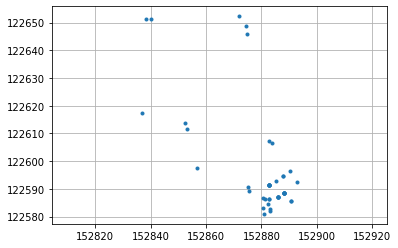

In [150]:
plt.plot(mdf['X'],mdf['Y'], '.')
plt.axis('equal')
plt.grid('on')

In [173]:
intervals.groupby('ID').count()['Type']>5

False